In [ ]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import MinMaxScaler

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
RUTA_CSV = '/content/drive/MyDrive/dataset.csv'

In [ ]:
def cargar_dataset(ruta_archivo):
    try:
        if not os.path.exists(ruta_archivo):
            raise FileNotFoundError(f"No se encontro el archivo: {ruta_archivo}")
        delimitadores = [';', ',', '\t']
        df = None

        for delim in delimitadores:
            try:
                df_temp = pd.read_csv(ruta_archivo, delimiter=delim, encoding='utf8')
                if df_temp.shape[1] > 1:
                    df = df_temp
                    print(f"Dataset cargado desde: {ruta_archivo}")
                    break
            except Exception:
                continue

        if df is None:
            df = pd.read_csv(ruta_archivo, delimiter=';')
            print(f"Dataset cargado desde: {ruta_archivo}")

        return df
    except Exception as e:
        print(f"Error al cargar el dataset: {e}")
        return None

In [ ]:
#Limpiar el dataset
def limpiar_dataset(df_segment):
  # Limpiar Distance (extraer solo el número)
  df_segment["Distance"] = df_segment["Distance"].astype(str).str.extract(r"(\d+)").astype(float)

  # Unir Date y Time → convertir a datetime
  df_segment["datetime"] = pd.to_datetime(df_segment["Date"] + " " + df_segment["Time"], dayfirst=True)

  # Extraer hora y día de semana
  df_segment["day_of_week"] = df_segment["datetime"].dt.dayofweek

  # Separar coordenadas de Stop
  df_segment[["stop_lat", "stop_lon"]] = df_segment["Stop Coordinate"].str.split(",", expand=True).astype(float)

  # Separar coordenadas de Log
  df_segment[["log_lat", "log_lon"]] = df_segment["Log Coordinate"].str.split(",", expand=True).astype(float)

  # Hora
  df_segment["hour"] = df_segment["datetime"].dt.hour

  # Minutos
  df_segment["minute"] = df_segment["datetime"].dt.minute

  # Segundos (opcional)
  df_segment["second"] = df_segment["datetime"].dt.second

  # Hora decimal (para capturar fracciones de hora)
  df_segment["hour_decimal"] = df_segment["hour"] + df_segment["minute"]/60 + df_segment["second"]/3600

  df_segment = df_segment.drop(columns=["Date", "Time", "Stop Coordinate", "Log Coordinate"])

  df_segment = df_segment.rename(columns={
      "Sequence": "segment",
      "Distance": "distance",
  })

  df_segment["distance_x_hour"] = df_segment["distance"] * df_segment["hour_decimal"]
  df_segment["peak_x_hour"] = df_segment["peak"] * df_segment["hour_decimal"]

  #Limpieza de datos vacíos o nulos
  df_clean = df_segment[(df_segment['distance'] != 0.0) & (df_segment['duration'] != 0.0)].copy()
  print(f"Datos originales: {len(df)} filas")
  print(f"Datos limpios: {len(df_clean)} filas")
  df_clean.reset_index(drop=True, inplace=True)

  return df_clean

In [ ]:
def filtrar_outliers(features, target, df_clean):
  Q1 = np.percentile(df_clean[target], 25)
  Q3 = np.percentile(df_clean[target], 75)
  IQR = Q3 - Q1
  limite_inferior = Q1 - 1.5 * IQR
  limite_superior = Q3 + 1.5 * IQR

  mask = (df_clean[target] >= limite_inferior) & (df_clean[target] <= limite_superior)
  df_filtrado = df_clean[mask].copy()

  X = df_filtrado[features].values
  y = df_filtrado[target].values.ravel()
  return X, y, df_filtrado


In [ ]:
def split_scaler(X,Y):
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

  # Escalado
  x_scaler = StandardScaler()
  X_train = x_scaler.fit_transform(X_train)
  X_test = x_scaler.transform(X_test)
  return X_train, X_test, y_train,y_test

In [ ]:
def preparar_datos(df_segment, features, target):
    df_clean = limpiar_dataset(df_segment)
    X, y, df_filtrado = filtrar_outliers(features, target, df_clean)
    X_train, X_test, y_train, y_test = split_scaler(X, y)
    return X_train, X_test, y_train, y_test, df_filtrado

In [ ]:
def entrenar_y_evaluar(modelo_func, X_train, X_test, y_train, y_test):
    y_pred = modelo_func(X_train, X_test, y_train, y_test)
    mae, mse, rmse, mape = metricas(y_test, y_pred)
    return mae, mse, rmse, mape

In [ ]:
def svr_model(X_train, X_test,y_train, y_test):
  param_grid = {
      'C': [1, 10, 50, 100],
      'epsilon': [0.1, 0.5, 1.0],
      'gamma': ['scale', 'auto', 0.01, 0.1, 1]
  }

  svr = SVR(kernel='rbf')
  grid = GridSearchCV(svr, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
  grid.fit(X_train, y_train)
  y_pred = grid.predict(X_test)
  return y_pred

In [ ]:
def rf_model(X_train, X_test,y_train, y_test):
  rf = RandomForestRegressor(n_estimators=1000, random_state=42)
  rf.fit(X_train, y_train)
  y_pred = rf.predict(X_test)
  return y_pred

In [ ]:
def gbr_model(X_train, X_test,y_train, y_test):
  gbr = GradientBoostingRegressor(
      n_estimators=1000,
      learning_rate=0.05,
      max_depth=4,
      random_state=42
  )
  gbr.fit(X_train, y_train)
  y_pred = gbr.predict(X_test)
  return y_pred

In [ ]:
def mlp_model(X_train, X_test,y_train, y_test):
  mlp = Sequential()
  mlp.add(Input(shape=(X_train.shape[1],)))
  mlp.add(Dense(64, activation="relu"))
  mlp.add(Dense(32, activation="relu"))
  mlp.add(Dense(1))
  mlp.compile(optimizer="adam", loss="mse", metrics=["mae"])
  mlp.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
  y_pred = mlp.predict(X_test)
  return y_pred

In [ ]:
#MÉTRICAS DE RENDIMIENTO
def metricas(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = math.sqrt(mse)
    mape = round(mean_absolute_percentage_error(y_test, y_pred) * 100,2)
    return mae, mse, rmse, mape

def print_metricas(mae, mse, rmse, mape):
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAPE: {mape * 100:.2f} %")

In [ ]:
def comparison_result(test, pred):
    pred = pred.flatten()

    #MOSTRAR TABLA DE COMPARACIÓN
    df_comparacion = pd.DataFrame({
        "Real (y_test)": test,
        "Predicho (y_pred)": np.round(pred, 2)
    })
    pd.set_option("display.max_rows", None)
    # Mostrar primeras filas
    print(df_comparacion)

In [ ]:
def estadisticas_segmento(df_segment, target):
    stats = {}
    stats["n_datos"] = len(df_segment)
    stats["media"] = df_segment[target].mean()
    stats["varianza"] = df_segment[target].var()
    stats["std"] = df_segment[target].std()
    stats["min"] = df_segment[target].min()
    stats["max"] = df_segment[target].max()
    return stats

In [ ]:
def plot_model_across_segments(df_resultados, metric):
    plt.figure(figsize=(12,6))
    sns.lineplot(x="segmento", y=metric, hue="modelo", data=df_resultados, marker="o")
    plt.title(f"{metric} en todos los segmentos por modelo")
    plt.ylabel(metric)
    plt.xlabel("Segmento")
    plt.show()

In [ ]:
def plot_variance_relation(df_resultados, metric):
    plt.figure(figsize=(8,6))
    sns.scatterplot(x="std_duracion", y=metric, hue="modelo", data=df_resultados)
    sns.regplot(x="std_duracion", y=metric, data=df_resultados, scatter=False, color="black")
    plt.title(f"Relación entre {metric} y desviación estándar de la duración")
    plt.xlabel("Desviación de la duración (target)")
    plt.ylabel(metric)
    plt.show()

In [ ]:
df = cargar_dataset(RUTA_CSV)

Dataset cargado desde: /content/drive/MyDrive/dataset.csv


In [ ]:
df.head()

,Sequence,Stop Name,Stop Coordinate,Check Time,Log Coordinate,Distance,Date,Time,duration,weather,peak
0,23,SEK MEN KEB TAMAN SEA (OPP) JLN SS2/3,"3.109894, 101.616525",6/2/2019 13:34,"3.1107317, 101.6180967",0,6/2/2019,13:34:51,0,1,0
1,1,LRT TMN BAHAGIA,"3.11068977010887, 101.612747206455",6/2/2019 13:36,"3.11079, 101.6142133",163 meter,6/2/2019,13:36:41,110,1,0
2,2,RUMAH NO. 57 JLN SS4A/1,"3.10767533424092, 101.611201364536",6/2/2019 13:39,"3.1091283, 101.611545",165 meter,6/2/2019,13:39:59,198,1,0
3,30,POH KONG JLN SS 2/55,"3.1172868, 101.6209125",6/2/2019 13:30,"3.118255, 101.6195283",0,6/2/2019,13:30:26,0,1,0
4,31,AUTO FILM JLNSS 2/24,"3.11521642915048, 101.621698417829",6/2/2019 13:32,"3.1162971, 101.621919",122 meter,6/2/2019,13:32:01,95,1,0


In [ ]:
def evaluar_segmentos(df, segmentos, features, target):
    resultados = []

    modelos = {
        "SVR": svr_model,
        "RandomForest": rf_model,
        "GradientBoosting": gbr_model,
        "MLP": mlp_model
    }

    for seg in segmentos:
        print(f"\n=== Segmento {seg} ===")
        try:
            df_segment = df[df["Sequence"] == seg].copy()
            df_segment.reset_index(drop=True, inplace=True)
            cols = ["Sequence", "Date", "Time", "Stop Coordinate", "Log Coordinate",
                    "Distance", "duration", "weather", "peak"]
            df_segment = df_segment[cols]
            X_train, X_test, y_train, y_test, df_filtrado = preparar_datos(df_segment,features, target)
            stats = estadisticas_segmento(df_filtrado, target)

            for nombre, modelo_func in modelos.items():
                mae, mse, rmse, mape = entrenar_y_evaluar(modelo_func, X_train, X_test, y_train, y_test)
                resultados.append([
                    seg, nombre, mae, mse, rmse, mape,
                    stats["n_datos"], stats["media"], stats["varianza"],
                    stats["std"], stats["min"], stats["max"]
                ])
        except Exception as e:
            print(f"Error en segmento {seg}: {e}")

    resultados_df = pd.DataFrame(resultados, columns=[
        "segmento", "modelo", "MAE", "MSE", "RMSE", "MAPE",
        "n_datos", "media_duracion", "varianza_duracion",
        "std_duracion", "min_duracion", "max_duracion"
    ])
    return resultados_df


=== Segmento 1 ===
Datos originales: 20261 filas
Datos limpios: 410 filas
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

=== Segmento 2 ===
Datos originales: 20261 filas
Datos limpios: 1206 filas
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

=== Segmento 3 ===
Datos originales: 20261 filas
Datos limpios: 624 filas
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

=== Segmento 4 ===
Datos originales: 20261 filas
Datos limpios: 1014 filas
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

=== Segmento 5 ===
Datos originales: 20261 filas
Datos limpios: 632 filas
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

=== Segmento 6 ===
Datos originales: 20261 filas
Datos limpios: 635 filas
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

=== Segmento 7 ===
Datos originales: 20261 filas
Datos limpios: 636 filas
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

=== Segmento 8 ===
Datos originales: 20261 filas
Datos limpios: 635 filas
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

=== Segmento 9 ===
Datos originales: 20261 filas
Datos limpios: 637 filas
5/5 ━━━━━━━━━━━━━

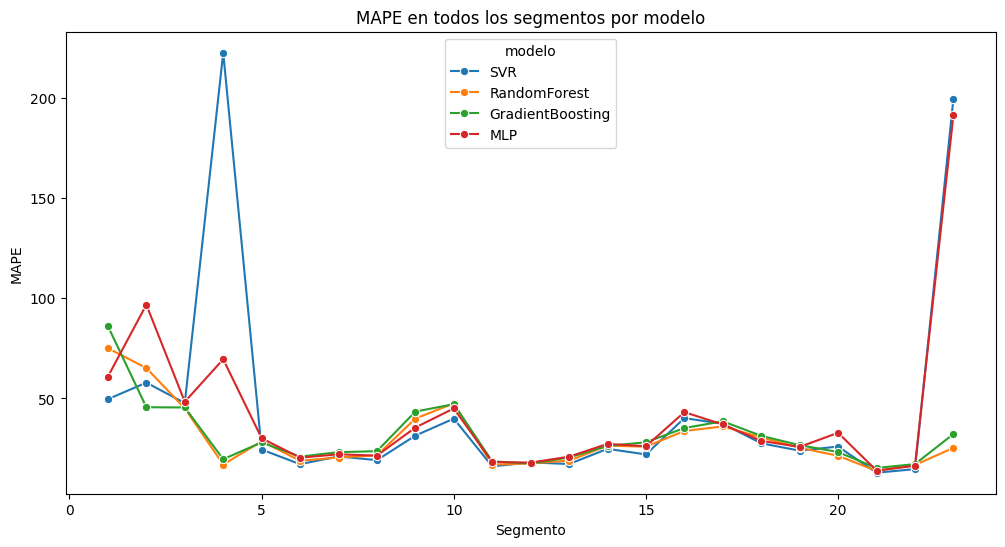

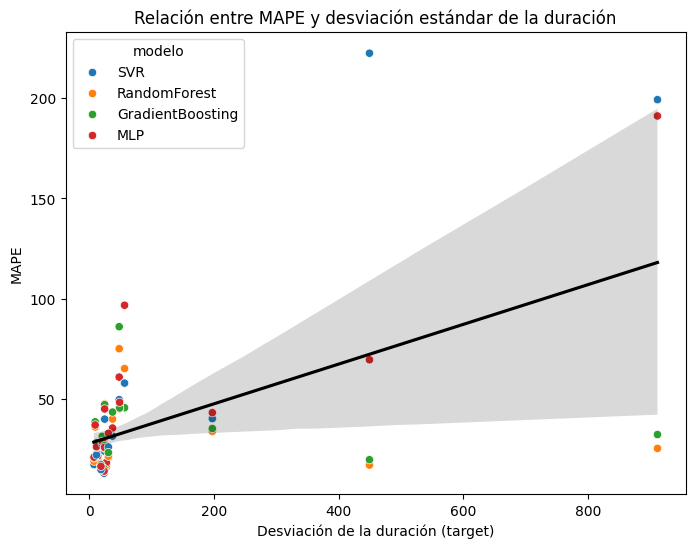

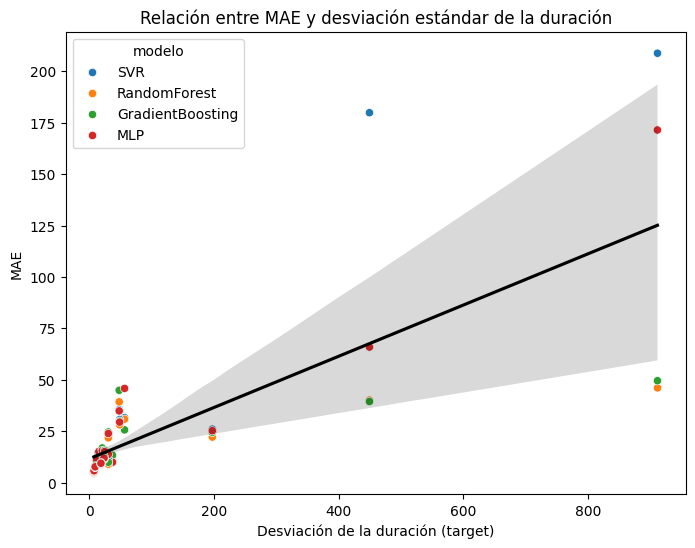

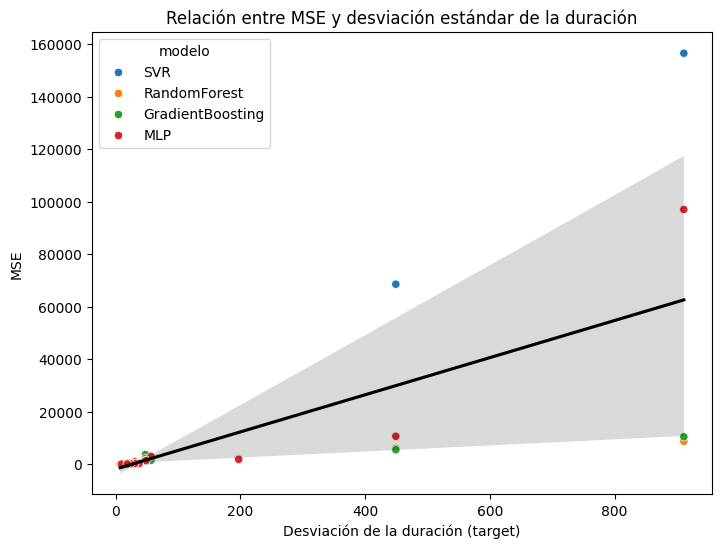

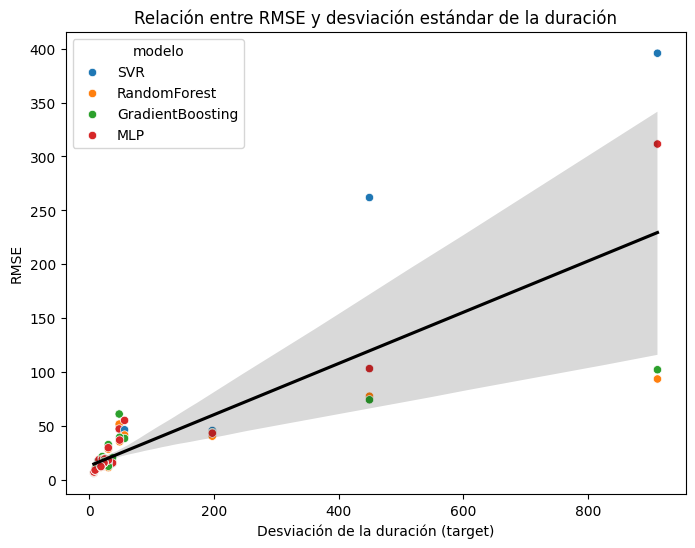

In [ ]:
features = ['distance', 'log_lat', 'log_lon', 'day_of_week', 'weather', 'peak',
            'hour', 'minute', 'second', 'hour_decimal', 'distance_x_hour', 'peak_x_hour']
target = "duration"

segmentos = list(range(1,24))

resultados_df = evaluar_segmentos(df, segmentos, features, target)
ruta = "/content/drive/MyDrive/resultados_modelos.csv"
resultados_df.to_csv(ruta, index=False)
print(f"Archivo guardado en: {ruta}")

plot_model_across_segments(resultados_df, metric="MAPE")
plot_variance_relation(resultados_df, metric="MAPE")
plot_variance_relation(resultados_df, metric="MAE")
plot_variance_relation(resultados_df, metric="MSE")
plot_variance_relation(resultados_df, metric="RMSE")


In [ ]:
df_resultados = cargar_dataset(ruta)

Dataset cargado desde: /content/drive/MyDrive/resultados_modelos.csv


In [ ]:
df_resultados.head()

,segmento,modelo,MAE,MSE,RMSE,MAPE,n_datos,media_duracion,varianza_duracion,std_duracion,min_duracion,max_duracion
0,1,SVR,35.467547,2557.193984,50.568706,49.64,403,64.583127,2302.303396,47.982324,20,195
1,1,RandomForest,39.269892,2699.172863,51.953564,75.06,403,64.583127,2302.303396,47.982324,20,195
2,1,GradientBoosting,44.895841,3756.673183,61.291706,86.05,403,64.583127,2302.303396,47.982324,20,195
3,1,MLP,34.863659,2251.860840,47.453776,60.91,403,64.583127,2302.303396,47.982324,20,195
4,2,SVR,31.598746,2179.708532,46.687349,57.90,1180,107.609322,3203.636045,56.600672,5,274


In [ ]:
promedios_modelos = df_resultados.groupby("modelo")[["MAE", "MSE", "RMSE", "MAPE"]].mean().reset_index()

print(promedios_modelos)

             modelo        MAE           MSE       RMSE       MAPE
0  GradientBoosting  18.220333   1287.744112  27.315064  31.068261
1               MLP  24.934235   5249.544193  37.253015  41.317826
2      RandomForest  17.266844   1139.790667  25.522766  29.941739
3               SVR  30.433515  10330.649308  47.313210  43.987391
